<a href="https://colab.research.google.com/github/ParsaRouzrokh/Keras-PlayGround/blob/main/Neural_Style_Transfer_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Modules

import tensorflow as tf
keras = tf.keras
from keras import layers
from keras.optimizers import optimizer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Collecting Image & Style

image_path = keras.utils.get_file(
    fname = "hogwarts" , origin = "https://i.ibb.co/yndwb7p/hogwarts.jpg"
)

style_path = keras.utils.get_file(
    fname = "starry_night.jpg", origin = "https://img-datasets.s3.amazonaws.com/starry_night.jpg"
)

943128/943128 [==============================] - 0s 0us/step


Size of the original image: (3000, 1688)

Size of the original style: (1160, 910)



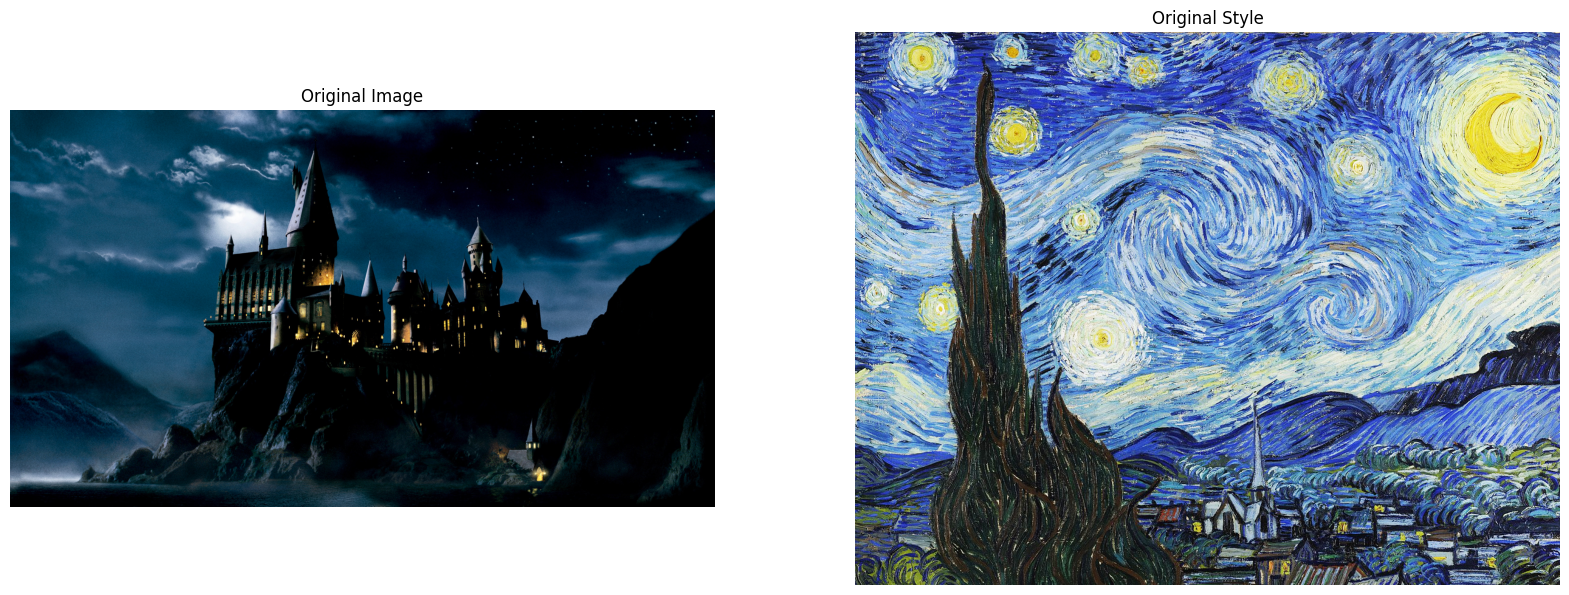

In [3]:
# Investigate the Original Image & Style

original_image = keras.utils.load_img(image_path)
original_style = keras.utils.load_img(style_path)
original_image_width , original_image_height = original_image.size
original_style_width , original_style_height = original_style.size

print(f"Size of the original image: {original_image.size}\n")
print(f"Size of the original style: {original_style.size}\n")

fig,axes = plt.subplots(1,2, figsize=(20,20))

# Display the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the original style image
axes[1].imshow(original_style)
axes[1].set_title('Original Style')
axes[1].axis('off')

plt.show()


In [4]:
# Setting New Size for Our Image, Style, and Combined Image

image_height = 350
ratio = image_height / original_image_height
image_width = round(original_image_width * ratio)

print(f"New size = {image_width , image_height}")

New size = (622, 350)


In [5]:
# Defining Preprocessor and Deprocessor based on VGG19 Preprocessing Values

def preprocess_image(image_path):
  image = keras.utils.load_img(image_path,target_size= (image_height , image_width))
  image = keras.utils.img_to_array(image)
  image = np.expand_dims(image,axis = 0)
  image = keras.applications.vgg19.preprocess_input(image)
  # includes:
    # mean = [103.939, 116.779, 123.68]
    # x[..., 0] -= mean[0]
    # x[..., 1] -= mean[1]
    # x[..., 2] -= mean[2]
    # + conversion RGB to BGR
  return image

def deprocess_image(image):
  image = image.reshape((image_height,image_width,3))

  # Decentralizing:
  image[:,:,0] += 103.939
  image[:,:,1] += 116.779
  image[:,:,2] += 123.68

  # Convert BGR to RGB
  image = image[:,:, ::-1]

  image = np.clip(image,0,255).astype("uint8")
  return image

In [6]:
# Loading Our Model

model = keras.applications.vgg19.VGG19(weights = "imagenet" , include_top = False)

80134624/80134624 [==============================] - 1s 0us/step


In [7]:
# Building an Output Dict to Form a Feature Extracting Model
# dict: {layer.name: layer.out}

output_dict = dict([(layer.name , layer.output) for layer in model.layers])
print(output_dict)

{'input_1': <KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>, 'block1_conv1': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>, 'block1_conv2': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>, 'block1_pool': <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_pool')>, 'block2_conv1': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>, 'block2_conv2': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>, 'block2_pool': <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_pool')>, 'block3_conv1': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>, 'block3_conv2': <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv2')>, 'block3_conv3': <KerasTensor

In [8]:
feature_extractor = keras.Model(inputs = model.inputs , outputs = output_dict)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
# Checking Our Extractor with Providing Inputs for it.
tensors = tf.concat(
    [preprocess_image(image_path),preprocess_image(style_path)],axis = 0
)

print(feature_extractor (tensors)["block5_conv2"].shape)

# channel (1: for image, 2: for style)

(2, 21, 38, 512)


In [10]:
# Defining Gram matrix to capture the correlations and textures present in our image,
# But do not contain any information about the actual content of the image.
# Gram matrices are computed by calculating the correlations between the
# different feature maps in a given layer of a convolutional neural network

def gram(x):
  # input: image x: (W,H,C)
  x = tf.transpose(x, (2,0,1)) # (C,W,H)
  features = tf.reshape(x, (tf.shape(x)[0],-1 )) # (C, W*H)
  gram = tf.matmul(features,tf.transpose(features))
  return gram

In [11]:
# Defining Loss Functions

# Gram doesn't have anything to do with Contents! So we use it only for Style_loss!
def style_loss(style_image , combination_image):
  # Trying to making the style of our combined image, same as the style of our style image!
  S = gram (style_image)
  C = gram (combination_image)
  channels = 3
  size = image_height * image_width
  return tf.reduce_sum(tf.square(S-C)) / (4.0 * (channels ** 2) * (size ** 2))
  # A normalization factor to ensure that the style loss is consistent across different image sizes and number of channels

def content_loss(base_image , combination_image):
  # Trying to making the content of our combined image, same as the content of our base image!
  return tf.reduce_mean(tf.square(combination_image - base_image))

# Optional: Total Regularization for loss based the adjacent pixels variations
def total_variation_loss (x):
  a = tf.square(
      x[:, : image_height - 1, : image_width -1 , :] - x[: , 1: , :image_width -1 , :]
  )
  b = tf.square(
      x[: , : image_height - 1 , :image_width - 1 , :] - x[ : , :image_height - 1 , 1: , :]
  )
  return tf.reduce_sum(tf.pow(a+b,1.25))

In [12]:
# Defining the layers used for style and content

# Chosing from a high level layer to preserve more content of the real image.
content_layer_name = "block4_conv2"

# Chosing from low-level layers to use a mixture of low-level and high-level style information to be extracted.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
]

In [13]:
# Setting Our Contribution Weights for content, style, & total!

total_variation_weight = 1e-6 # Don't Change it!
style_weight = 2e-6
content_weight = 0.1e-8

# Based on personal experience:
# Style: 1 , Content: 2.5 => low
# Style: 2 , Content: 0.1 => Moderate
# Style: 2.5 , Content: 0.01 => High

In [14]:
# Defining our Final loss by Passing our inputs and calculating each of the losses defined before:
# Final_Loss = Content Loss + Style Loss + Total Loss

def compute_loss (base, style, combination):

  # 1) Content Loss:

  input_tensor = tf.concat([base , style ,combination],axis = 0)
  # [0: for base, 1: for style, 2: for combination]
  features = feature_extractor(input_tensor)

  loss = tf.zeros(shape=())
  base_layer_features = features[content_layer_name]
  image_features = base_layer_features[0,:,:,:]
  combination_features = base_layer_features[2,:,:,:]
  loss += content_weight * content_loss (image_features , combination_features)

  # 2) Style Loss:

  for layer_name in style_layer_names:
    style_layer_features = features[layer_name]
    style_features = style_layer_features[1,:,:,:]
    combination_features = style_layer_features[2,:,:,:]
    style_loss_value = style_loss(style_features, combination_features)

    # Ensuring that the style loss contribution from each style layer is scaled down equally.
    loss += (style_weight / len(style_layer_names)) * style_loss_value

  # 3) Total Loss:
  loss += total_variation_weight * total_variation_loss(combination)

  return loss

In [15]:
# Calculating our loss and grads
@tf.function
def loss_grads (base, style , combination):
  with tf.GradientTape() as tape:
    loss = compute_loss(base, style, combination)
  grads = tape.gradient(loss,combination)
  return loss,grads

# Defining Our optimizer (Using ExponentialDecay here)
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 100.0 , decay_steps = 100 , decay_rate = 0.96))

# Let's finalize our art...

base = preprocess_image(image_path)
style = preprocess_image(style_path)
combination = tf.Variable(base)

iterations = 5000

for i in range(iterations):
  loss,grads = loss_grads(base , style , combination)
  optimizer.apply_gradients([(grads,combination)])
  if (i+1) % 100 == 0:
    print(f"iteration {i+1}: loss = {loss:.2f}")
    img = deprocess_image(combination.numpy())
    keras.utils.save_img(f"style{i+1}.png",img)

iteration 100: loss = 12538.12
iteration 200: loss = 9920.27
iteration 300: loss = 8868.27
iteration 400: loss = 8698.14
iteration 500: loss = 8248.24
iteration 600: loss = 7945.47
iteration 700: loss = 7753.96
iteration 800: loss = 7674.74
iteration 900: loss = 7694.18
iteration 1000: loss = 7404.19
iteration 1100: loss = 7330.57
iteration 1200: loss = 7248.41
iteration 1300: loss = 7184.68
iteration 1400: loss = 7128.61
iteration 1500: loss = 7079.17
iteration 1600: loss = 7035.50
iteration 1700: loss = 6996.39
iteration 1800: loss = 6961.23
iteration 1900: loss = 6929.19
iteration 2000: loss = 6899.84
iteration 2100: loss = 6872.90
iteration 2200: loss = 6848.13
iteration 2300: loss = 6825.27
iteration 2400: loss = 6804.18
iteration 2500: loss = 6784.56
iteration 2600: loss = 6766.34
iteration 2700: loss = 6749.35
iteration 2800: loss = 6733.52
iteration 2900: loss = 6718.74
iteration 3000: loss = 6704.86
iteration 3100: loss = 6691.84
iteration 3200: loss = 6679.63
iteration 3300: 

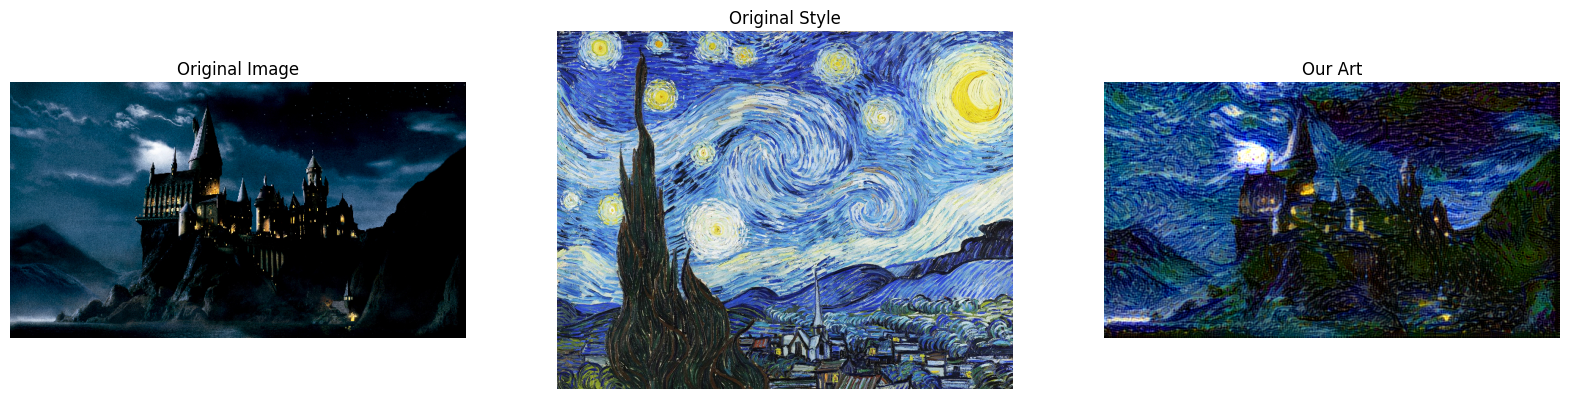

In [18]:
# Not let's visualize it

fig,axes = plt.subplots(1,3, figsize=(20,20))

# Display the original image
image = keras.utils.load_img(image_path,target_size= (image_height , image_width))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the original style image
style = keras.utils.load_img(style_path,target_size= (image_height , image_width))
axes[1].imshow(original_style)
axes[1].set_title('Original Style')
axes[1].axis('off')

# Display our final image
combined = keras.utils.load_img("style5000.png",target_size= (image_height, image_width))
axes[2].imshow(combined)
axes[2].set_title("Our Art")
axes[2].axis('off')

plt.show()